In [1]:
from collections import deque

To make simulating sending pulses easier, let's build some classes to handle the simulating; one class for each type of module.

In [2]:
class Broadcaster:
    def __init__(self) -> None:
        self.after = []
    
    def conn_to(self, targets):
        self.after.extend(targets)
    
    def conn_from(self, source):
        pass

    def pulse(self, source, hilo):
        return [(x, hilo) for x in self.after]
    
    def get_state(self):
        return 'b'
    
class FlipFlop:
    def __init__(self) -> None:
        self.state = 'off'
        self.after = []
    
    def conn_to(self, targets):
        self.after.extend(targets)
    
    def conn_from(self, source):
        pass

    def pulse(self, source, hilo):
        if hilo == 'high':
            return []
        out = 'high' if self.state == 'off' else 'low'
        self.state = 'on' if self.state == 'off' else 'off'
        return [(x, out) for x in self.after]
    
    def get_state(self):
        return self.state

class Conjunction:
    def __init__(self) -> None:
        self.prev = {}
        self.after = []
    
    def conn_to(self, targets):
        self.after.extend(targets)
    
    def conn_from(self, source):
        self.prev[source] = 'low'

    def pulse(self, source, hilo):
        self.prev[source] = hilo
        if 'low' in self.prev.values():
            out = 'high'
        else:
            out = 'low'
        return [(x, out) for x in self.after]
    
    def get_state(self):
        return str(self.prev.values())

# Part 1

Parse the input twice. First round we create all module objects and set their outward connections. On the second round we set the incoming connections for the conjection modules.

In [3]:
modules = {}

filepath = "./data/day20.txt"

with open(filepath) as f:
    while line := f.readline():
        line = line.rstrip().split(' -> ')
        if line[0][0] == '%':
            m = line[0][1:]
            modules[m] = FlipFlop()
        elif line[0][0] == '&':
            m = line[0][1:]
            modules[m] = Conjunction()
        else:
            m = line[0]
            modules[m] = Broadcaster()
        targets = line[1].replace(',', '').split(' ')
        modules[m].conn_to(targets)

with open(filepath) as f:
    while line := f.readline():
        line = line.rstrip().split(' -> ')
        if line[0][0] == '%':
            m = line[0][1:]
        elif line[0][0] == '&':
            m = line[0][1:]
        else:
            m = line[0]
        targets = line[1].replace(',', '').split(' ')
        for t in targets:
            if t in modules:
                modules[t].conn_from(m)

In [4]:
modules.keys()

dict_keys(['pr', 'jg', 'mg', 'mq', 'db', 'dx', 'bd', 'qj', 'xs', 'xd', 'gb', 'nt', 'ht', 'rh', 'sq', 'tt', 'dh', 'rz', 'cx', 'zq', 'jm', 'lj', 'mp', 'dz', 'fz', 'hj', 'broadcaster', 'zc', 'pj', 'bn', 'mr', 'mj', 'gg', 'sh', 'bf', 'hf', 'bm', 'bk', 'pq', 'xf', 'th', 'fx', 'ff', 'xr', 'bq', 'zz', 'gz', 'zs', 'vd', 'vk', 'cv', 'cd', 'zg', 'gd', 'ql', 'lt', 'ds', 'vp'])

With these classes simulating the pulse is extremely simple:

In [5]:
def run_pulse():
    lows = 0
    highs = 0
    q = deque()
    q.append(('button', 'broadcaster', 'low'))
    while q:
        source, target, hilo = q.pop()
        if hilo == 'low':
            lows += 1
        else:
            highs += 1
        if target not in modules:
            continue
        ls = modules[target].pulse(source, hilo)
        for new_target, new_hilo in ls:
            q.appendleft((target, new_target, new_hilo))
    return (lows, highs)

For part 1 the number of rounds is low enough that we can simply run the simulation 1000 times to get our answer.

In [6]:
lows, highs = 0, 0
for _ in range(1000):
    a, b = run_pulse()
    lows += a
    highs += b
lows, highs, lows*highs

(17827, 46109, 821985143)

# Part 2

Reset states by just reparsing input.

In [7]:
modules = {}

filepath = "./data/day20.txt"

with open(filepath) as f:
    while line := f.readline():
        line = line.rstrip().split(' -> ')
        if line[0][0] == '%':
            m = line[0][1:]
            modules[m] = FlipFlop()
        elif line[0][0] == '&':
            m = line[0][1:]
            modules[m] = Conjunction()
        else:
            m = line[0]
            modules[m] = Broadcaster()
        targets = line[1].replace(',', '').split(' ')
        modules[m].conn_to(targets)

with open(filepath) as f:
    while line := f.readline():
        line = line.rstrip().split(' -> ')
        if line[0][0] == '%':
            m = line[0][1:]
        elif line[0][0] == '&':
            m = line[0][1:]
        else:
            m = line[0]
        targets = line[1].replace(',', '').split(' ')
        for t in targets:
            if t in modules:
                modules[t].conn_from(m)

If it was possible to get the answer by simply running the simulation until we see that `rx` received a low pulse, this function would do it.

In [8]:
def run_pulse2():
    q = deque()
    q.append(('button', 'broadcaster', 'low'))
    while q:
        source, target, hilo = q.pop()
        if target == 'rx' and hilo == 'low':
            return True
        if target not in modules:
            continue
        ls = modules[target].pulse(source, hilo)
        for new_target, new_hilo in ls:
            q.appendleft((target, new_target, new_hilo))
    return False

Running simulations with the above run_pulse2 never finishes. Time for manual checking of what is going on.

Looking at the input, the only module that pulses to `rx` is the conjunction module `mg`. It's previous modules are:

In [9]:
modules['mg'].prev

{'jg': 'low', 'rh': 'low', 'jm': 'low', 'hf': 'low'}

In [10]:
for label in ['jg', 'rh', 'jm', 'hf']:
    print(type(modules[label]))

<class '__main__.Conjunction'>
<class '__main__.Conjunction'>
<class '__main__.Conjunction'>
<class '__main__.Conjunction'>


So let's try looking for some loops. Let's see if these modules pulse high beams to `mg` in a way that is a simple loop.

In [11]:
def run_pulse3():
    monitor = ['jg', 'rh', 'jm', 'hf']
    res = {x:[] for x in monitor}
    q = deque()
    q.append(('button', 'broadcaster', 'low'))
    while q:
        source, target, hilo = q.pop()
        if source in monitor:
            res[source].append(hilo)
        if target not in modules:
            continue
        ls = modules[target].pulse(source, hilo)
        for new_target, new_hilo in ls:
            q.appendleft((target, new_target, new_hilo))
    return res

In [12]:
hi_pulses = {x:[] for x in ['jg', 'rh', 'jm', 'hf']}
for i in range(20000):
    res = run_pulse3()
    for k, v in res.items():
        if 'high' in v:
            hi_pulses[k].append(i+1)

In [13]:
for k, v in hi_pulses.items():
    print(k)
    print(v)
    print([v[i+1]-v[i] for i in range(len(v)-1)])

jg
[3793, 7586, 11379, 15172, 18965]
[3793, 3793, 3793, 3793]
rh
[4019, 8038, 12057, 16076]
[4019, 4019, 4019]
jm
[4003, 8006, 12009, 16012]
[4003, 4003, 4003]
hf
[3947, 7894, 11841, 15788, 19735]
[3947, 3947, 3947, 3947]


Indeed they seem like they do. This isn't conclusive proof but let's assume that they keep looping like this forever. Under this assumption the first time they have all pulsed a high beam to `mg` is during the round $\text{lcm}(3793, 4019, 4003, 3947)$.

In [14]:
from math import lcm

lcm(3793, 4019, 4003, 3947)

240853834793347

# Part 2 proof

Let's try to prove that the part 2 solution actually works. First, let's visualize the graph.

In [15]:
import graphviz

In [16]:
graph = graphviz.Digraph('module-graph')

for label in modules.keys():
    graph.node(label, label)

with open(filepath) as f:
    while line := f.readline():
        line = line.rstrip().split(' -> ')
        if line[0][0] == '%':
            m = line[0][1:]
        elif line[0][0] == '&':
            m = line[0][1:]
        else:
            m = line[0]
        targets = line[1].replace(',', '').split(' ')
        for t in targets:
            graph.edge(m, t)

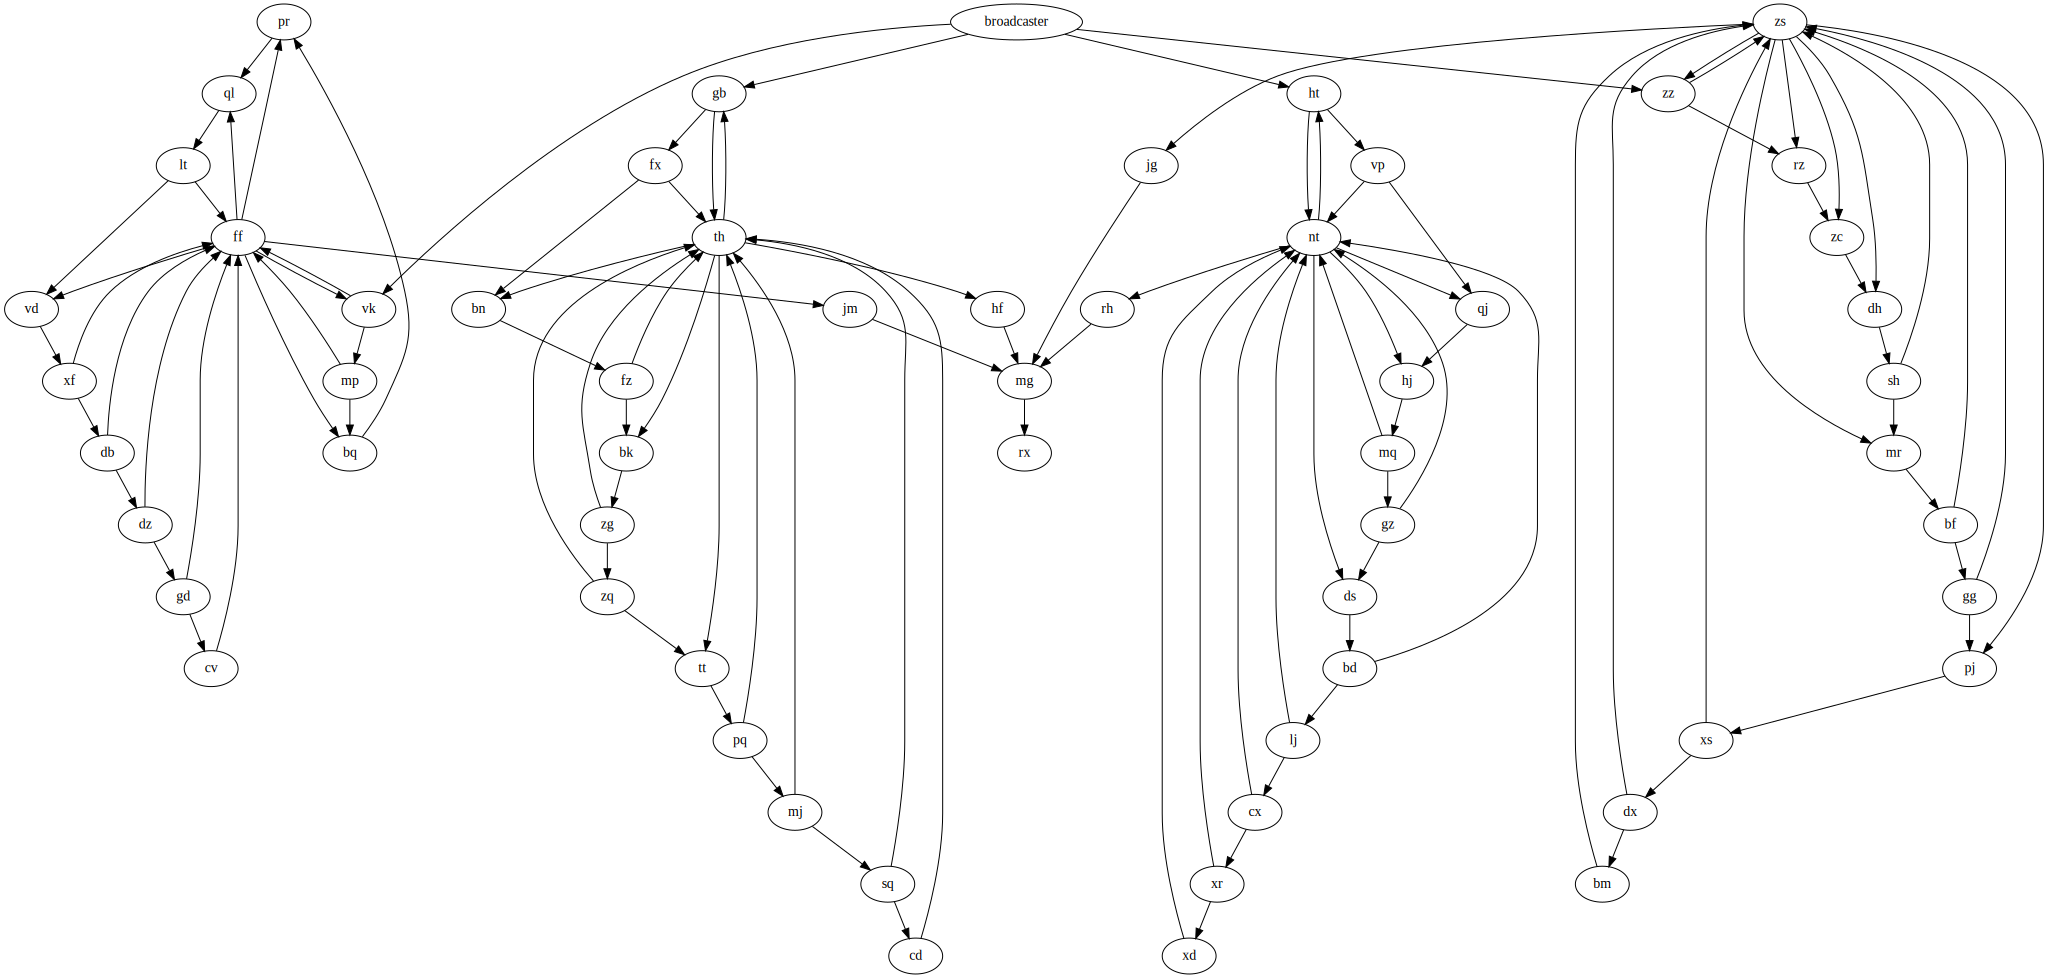

In [17]:
graph

From this picture we see that the graph can be seen as the broadcaster feeding into four "black boxes"/subgraphs which feed a single signal to `mg` which finally feeds a signal to `rx`. Now, to verify that our looping idea actually works, we need to compute the loops of each of the four subgraphs and verify that the loops end with a high pulse being sent out.

To make things easier, let's write a function that reparses the modules to reset the state of the modules.

In [18]:
def reset_state():
    global modules

    filepath = "./data/day20.txt"

    with open(filepath) as f:
        while line := f.readline():
            line = line.rstrip().split(' -> ')
            if line[0][0] == '%':
                m = line[0][1:]
                modules[m] = FlipFlop()
            elif line[0][0] == '&':
                m = line[0][1:]
                modules[m] = Conjunction()
            else:
                m = line[0]
                modules[m] = Broadcaster()
            targets = line[1].replace(',', '').split(' ')
            modules[m].conn_to(targets)

    with open(filepath) as f:
        while line := f.readline():
            line = line.rstrip().split(' -> ')
            if line[0][0] == '%':
                m = line[0][1:]
            elif line[0][0] == '&':
                m = line[0][1:]
            else:
                m = line[0]
            targets = line[1].replace(',', '').split(' ')
            for t in targets:
                if t in modules:
                    modules[t].conn_from(m)

Then, Let's write a function that simulates a pulse being sent into each subgraph.

In [19]:
def run_pulse4(first, last):
    res = []
    q = deque()
    q.append(('broadcaster', first, 'low'))
    while q:
        source, target, hilo = q.pop()
        if source == last:
            res.append(hilo)
            continue
        if target not in modules:
            continue
        ls = modules[target].pulse(source, hilo)
        for new_target, new_hilo in ls:
            q.appendleft((target, new_target, new_hilo))
    return res

Now, to detect loops, we need a function that serializes the entire state of the graph.

In [20]:
def total_state():
    res = ''
    for m in sorted(modules.keys()):
        res += modules[m].get_state()
    return res

Now, we have everything we need to find loops for each subgraph and see what the last pulses out of the subgraphs are.

In [21]:
for first, last in [['vk', 'jm'], ['gb', 'hf'], ['ht', 'rh'], ['zz', 'jg']]:
    reset_state()
    states = {}
    curr_state = total_state()
    counter = 0
    hi_rounds = []
    while curr_state not in states:
        states[curr_state] = counter
        counter += 1
        res = run_pulse4(first, last)
        if 'high' in res:
            hi_rounds.append((counter, res))
        curr_state = total_state()
    print(f'Subgraph {first} -> {last}: Loop {states[curr_state]} - {counter}, len {counter-states[curr_state]}')
    print('Round with high pulses:', hi_rounds)

Subgraph vk -> jm: Loop 1 - 4004, len 4003
Round with high pulses: [(4003, ['high', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low'])]
Subgraph gb -> hf: Loop 1 - 3948, len 3947
Round with high pulses: [(3947, ['high', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low'])]
Subgraph ht -> rh: Loop 1 - 4020, len 4019
Round with high pulses: [(4019, ['high', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low'])]
Subgraph zz -> jg: Loop 1 - 3794, len 3793
Round with high pulses: [(3793, ['high', 'low', 'low', 'low', 'low', 'low', 'low', 'low'])]


Oh, the loops actually don't end with a high pulse. Instead, the round that sends a high pulse always starts with a high pulse. Well, at least we now know that the loops do really exist and we know that $\text{lcm}(3793, 4019, 4003, 3947)$ is the earliest possible round where `rx` can get a low pulse.

What we can do now is simulate the subgraphs separately to get them to the state just before the round when they emit the high pulses. Then we simply run a single simulation on the entire graph to see if `rx` actually gets the low pulse.

In [22]:
reset_state()
for _ in range(4003-1):
    run_pulse4('vk', 'mg')
for _ in range(3947-1):
    run_pulse4('gb', 'mg')
for _ in range(4019-1):
    run_pulse4('ht', 'mg')
for _ in range(3793-1):
    run_pulse4('zz', 'mg')

In [23]:
run_pulse2()

True

IT DOES!

Thus, $\text{lcm}(3793, 4019, 4003, 3947)$ is the first round where `rx` gets a low pulse and the machine turns on.